# Punto 2

**Integrantes:** Juliana Bermúdez y Valentina Herrera

**Objetivo** Predecir el número total de bicicletas alquiladas (cnt) en un día, utilizando un modelo de
regresión con kernel basado en características como condiciones climáticas, temporada,
hora del día, temperatura, etc.

## Carga y preprocesamiento

A continuación importamos las librerías que vamos a utilizar.

In [ ]:
import numpy as np
from functools import partial
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tabulate import tabulate
from matplotlib import pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.linalg import LinAlgWarning
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from statsmodels.formula.api import ols
from typing import Literal, Any
from sklearn.model_selection import KFold, cross_validate
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsRegressor
from typing import Tuple

Importamos los datos como un dataframe de Pandas.

In [ ]:
df = pd.read_csv('/content/day.csv')

In [ ]:
df = df.dropna()

In [ ]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
df.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


De primera mano, podemos ver que cada entrada corresponde a un día, razón por la que se puede quitar la fecha e instant dado que no son variables predictoras sino identificadoras.

Utilizamos ```info()``` para ver de forma general los datos e identificar en qué aspectos requiere preprocesamiento.

In [ ]:
df = df.drop(columns = ['dteday','instant'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   yr          731 non-null    int64  
 2   mnth        731 non-null    int64  
 3   holiday     731 non-null    int64  
 4   weekday     731 non-null    int64  
 5   workingday  731 non-null    int64  
 6   weathersit  731 non-null    int64  
 7   temp        731 non-null    float64
 8   atemp       731 non-null    float64
 9   hum         731 non-null    float64
 10  windspeed   731 non-null    float64
 11  casual      731 non-null    int64  
 12  registered  731 non-null    int64  
 13  cnt         731 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 80.1 KB


Identificamos que no hay valores nulos y por tanto no es necesario hacer interpolación o eliminar variables por falta de datos. Sin embargo, analizando la escencia de las variables, se identifica que hay variables almacenadas como enteros que verdaderamente son variables categóricas que ya han sido codificadas. Luego, variables como season, yr, mnth, holiday, weekday, workingday y weathersit van a ser procesadas como categóricas.

In [ ]:
categorical_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

for col in categorical_cols:
    df[col] = df[col].astype('object')

## Exploración de datos

### Variables categóricas

In [ ]:
categorical_cols = df.select_dtypes(include=['object'])
categorical_cols.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit
0,1,0,1,0,6,0,2
1,1,0,1,0,0,0,2
2,1,0,1,0,1,1,1
3,1,0,1,0,2,1,1
4,1,0,1,0,3,1,1


**Diagrama de barras**

Dada la naturaleza de las variables, procedemos a hacer diagrama de barras.

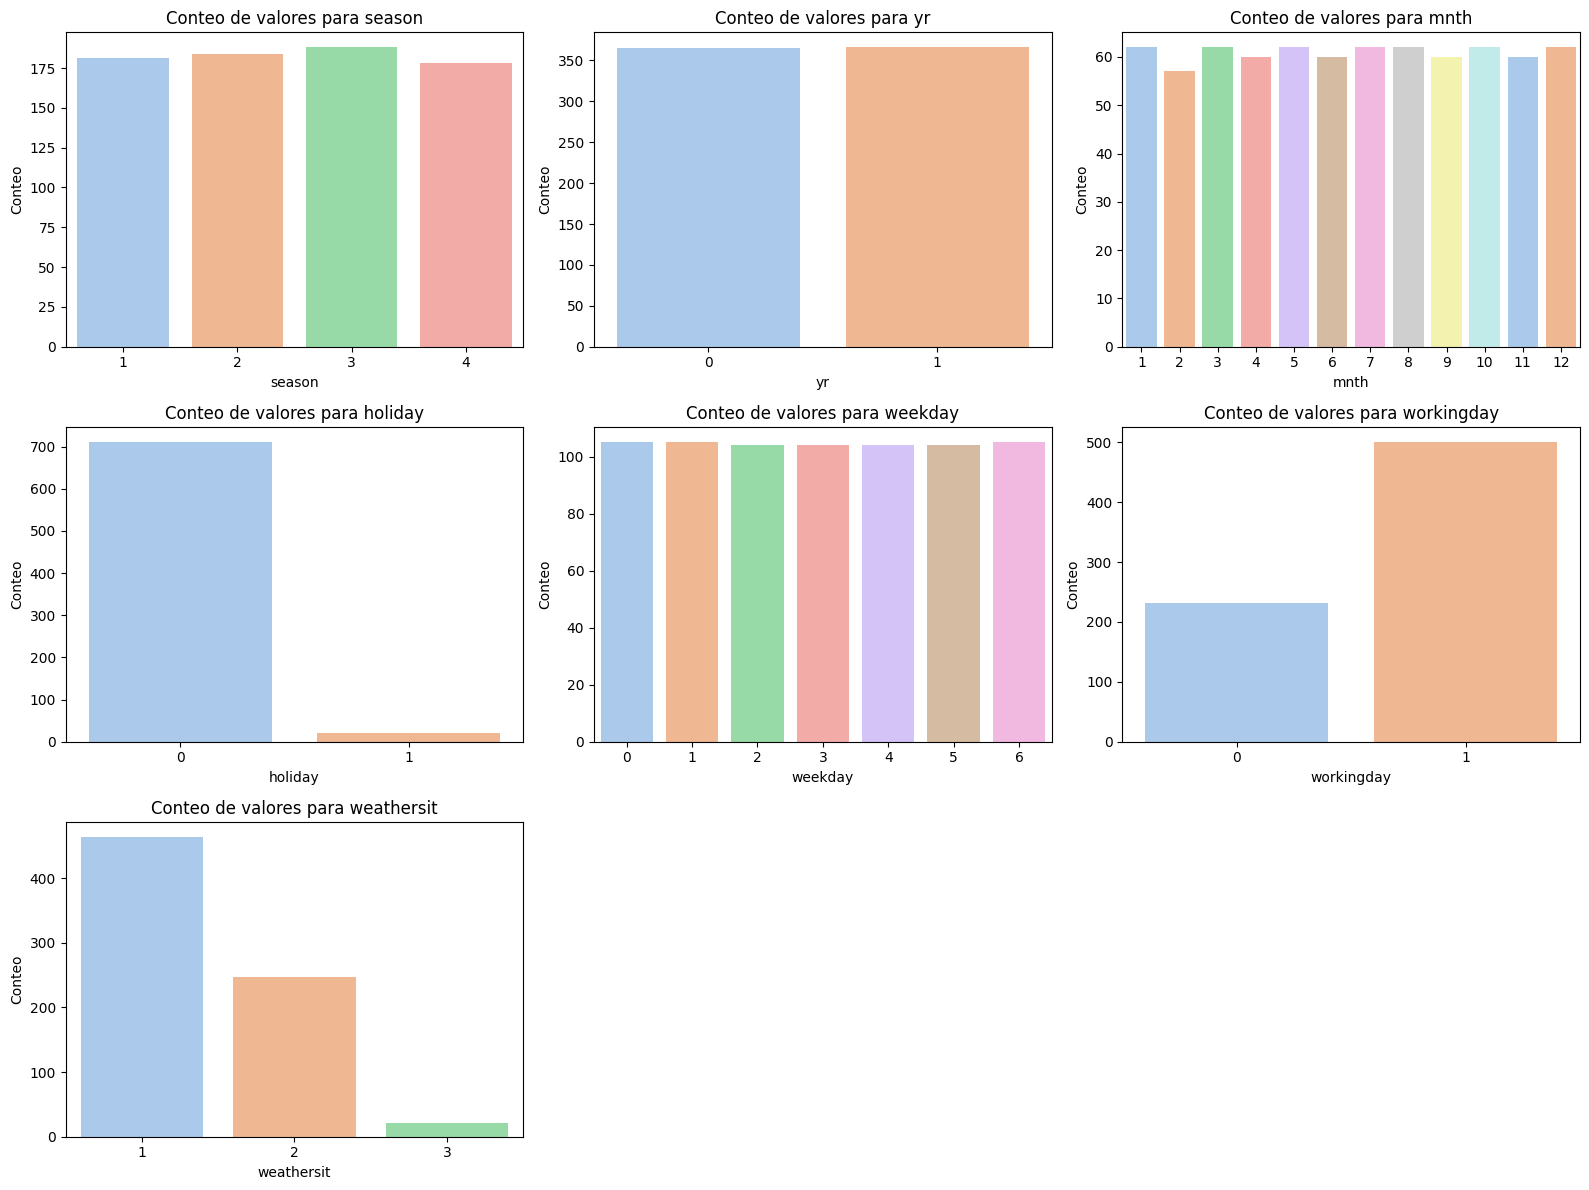

In [ ]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

plt.figure(figsize=(16, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=col, data=df, palette='pastel')
    plt.title(f'Conteo de valores para {col}')
    plt.xlabel(col)
    plt.ylabel('Conteo')
plt.tight_layout()
plt.show()

Del diagrama de barras, podemos evidenciar que la mayoría de de datos en las variables están distribuidos homogeneamente entre sus categorías. Sin embargo, en la variable holiday casi todos están en la categoría codificada como 0.

**Boxplot**

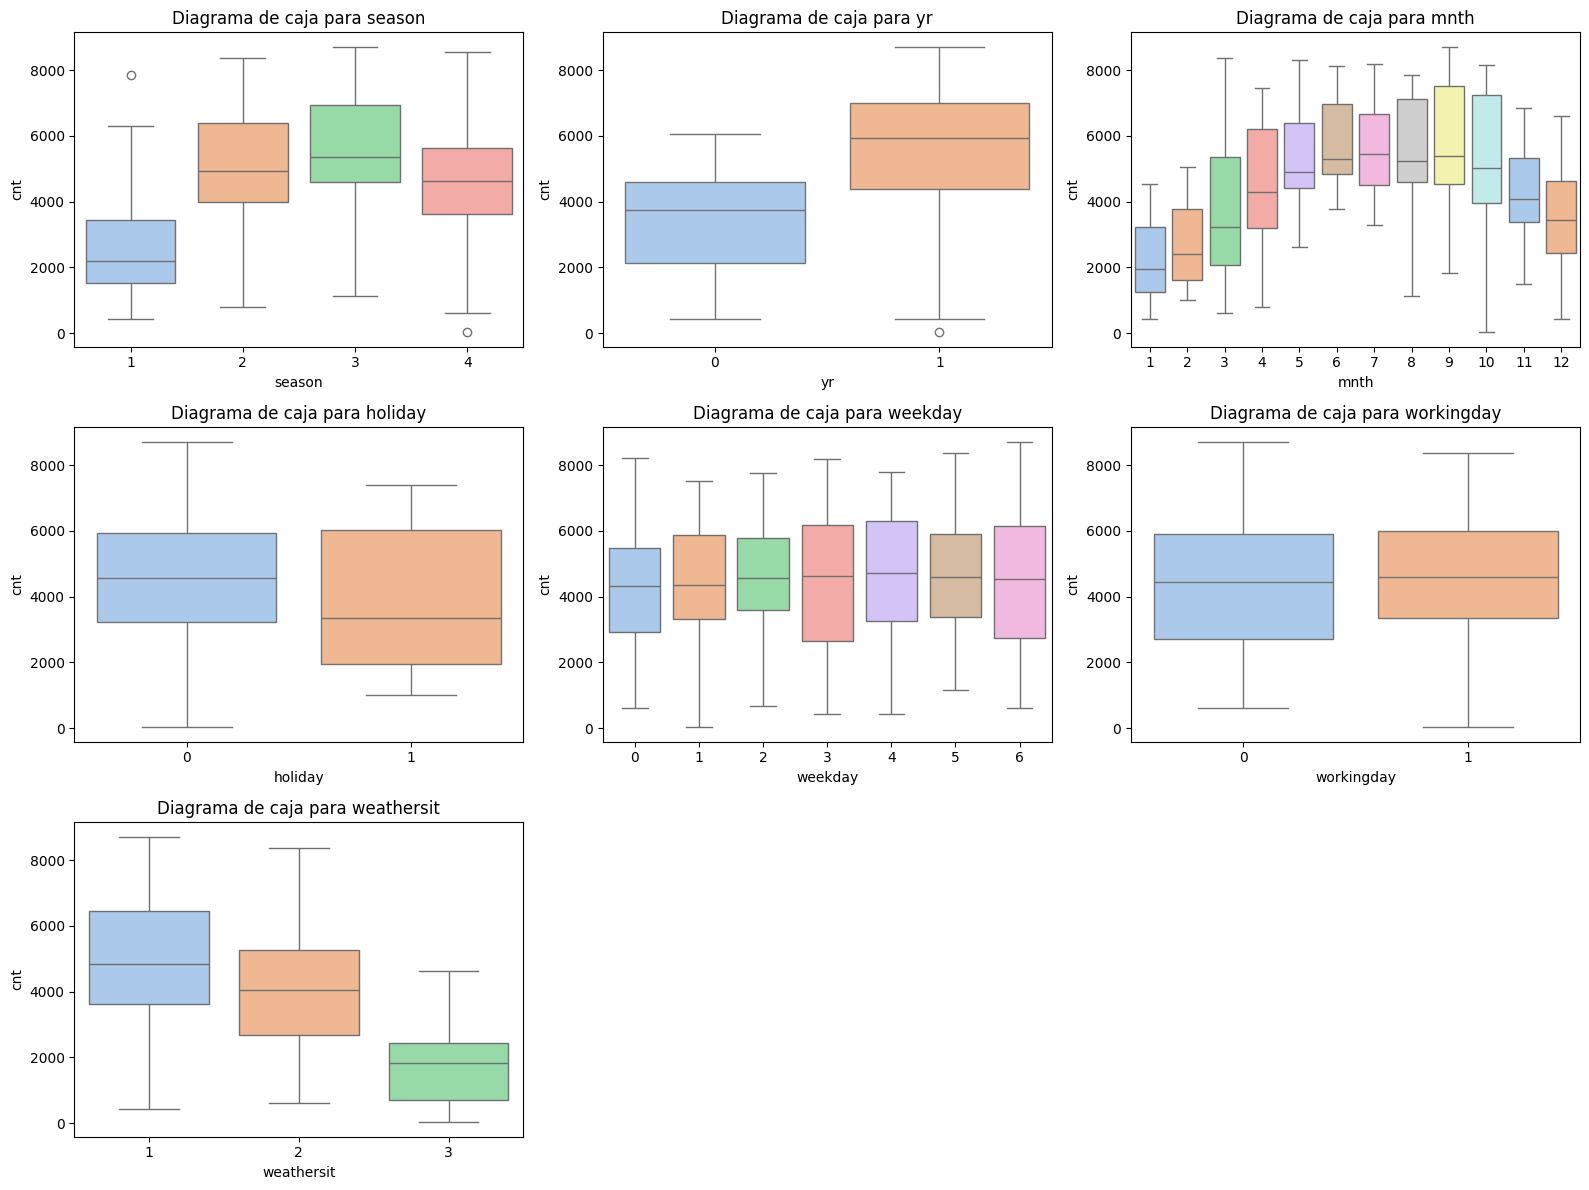

In [ ]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

plt.figure(figsize=(16, 12))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=col, y='cnt', data=df, palette='pastel')
    plt.title(f'Diagrama de caja para {col}')
    plt.xlabel(col)
    plt.ylabel('cnt')
plt.tight_layout()
plt.show()

En lo que respecta a los diagramas de caja, se evidencia que en algunas variables como weekday y workingday las medias están casi que en el mismo nivel todos los días y los cuartiles tampoco distan por mucho. Por tanto, se podría decir que en estos casos los días de la semana no influirían tan considerablemente en el cnt. Al mismo tiempo, hay varibales como season y month donde a partir de las medias se puede ver superificialmente un tipo de comportamiento casi que normal, llevando a pensar que la relación puede tener una distribución de este tipo. Por otro lado, hay boxplots donde las medias y las amplitudes de los cuartiles distan en una misma variable, como es el caso de weathershit y yr.

**Anova**


In [ ]:
results = []
for col in categorical_cols.columns:
    modelo = ols('cnt ~ C('+col+')', data=df).fit()
    resultados_anova = sm.stats.anova_lm(modelo, typ=2)
    p_valor = resultados_anova.loc['C('+col+')', 'PR(>F)']
    results.append({'Columna': col, 'P_Value': p_valor})

df_anova = pd.DataFrame(results)
print(df_anova)


      Columna       P_Value
0      season  6.720391e-67
1          yr  2.483540e-63
2        mnth  4.251077e-70
3     holiday  6.475936e-02
4     weekday  5.834941e-01
5  workingday  9.849496e-02
6  weathersit  3.106317e-17


Para nuestras variables categoricas podemos decir que con respecto al ánalisis de varianza ANOVA realizado con respecto el número total de bicicletas alquiladas en un día, las variables season, yr, mnth y weathersit tienen un impacto significativo con nuestra variable. Por otro lado, las variables holiday y workingday afectan cnt pero no muestran ser tan significativas. Finalmente, weekday no pasa la prueba y por tanto no tiene una influencia significativa, lo cual corrobora el análisis gráfico realizado sobre el diagrama de barras y el boxplot. Estos hallazgos resaltan la importancia de considerar ciertas variables al predecir el número total de bicicletas alquiladas, mientras que otras pueden no ser relevantes para este propósito. Por consiguiente, eliminamos weekday.

In [ ]:
categorical_cols = categorical_cols.drop(columns=['weekday'])

### Variables númericas

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
numeric_cols.head()

,temp,atemp,hum,windspeed,casual,registered,cnt
0,0.344167,0.363625,0.805833,0.160446,331,654,985
1,0.363478,0.353739,0.696087,0.248539,131,670,801
2,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,0.226957,0.229270,0.436957,0.186900,82,1518,1600


**Correlación de Pearson**

In [ ]:
correlaciones_pearson = numeric_cols.corr(method='pearson')
correlaciones_kendall = numeric_cols.corr(method='kendall')
correlaciones_spearman = numeric_cols.corr(method='spearman')

y = 'cnt'

# Pearson
df_correlacion_pearson = pd.DataFrame(correlaciones_pearson[y]).reset_index().rename(columns={'index':'Columna', y:'Pearson'})

# Kendall
df_correlacion_kendall = pd.DataFrame(correlaciones_kendall[y]).reset_index().rename(columns={'index':'Columna', y:'Kendall'})

# Spearman
df_correlacion_spearman = pd.DataFrame(correlaciones_spearman[y]).reset_index().rename(columns={'index':'Columna', y:'Spearman'})


df_correlacion = df_correlacion_pearson.merge(df_correlacion_kendall, on='Columna').merge(df_correlacion_spearman, on='Columna')

for columna in ['Pearson', 'Kendall', 'Spearman']:
    df_correlacion[columna] = df_correlacion.apply(lambda x: '\033[1;31m'+str(x[columna])+'\033[0m' if abs(x[columna]) < 0.2 else x[columna], axis=1)
print(tabulate(df_correlacion, headers='keys', tablefmt='psql'))

+----+------------+-----------+------------+------------+
|    | Columna    |   Pearson |    Kendall |   Spearman |
|----+------------+-----------+------------+------------|
|  0 | temp       |  0.627494 |  0.432009  |  0.622034  |
|  1 | atemp      |  0.631066 |  0.432185  |  0.622782  |
|  2 | hum        | -0.100659 | -0.0692299 | -0.0981258 |
|  3 | windspeed  | -0.234545 | -0.14711   | -0.217197  |
|  4 | casual     |  0.672804 |  0.560225  |  0.753501  |
|  5 | registered |  0.945517 |  0.810807  |  0.940319  |
|  6 | cnt        |  1        |  1         |  1         |
+----+------------+-----------+------------+------------+


Teniendo en cuenta las tres correlaciones empleadas, se pensaría que eliminar hum es una buena medida. Esto, dado que no está correlacionada significativamente. Por otro lado, se podría pensar en eliminar windspeed pero con los demás test se comprobará si efectivamente es necesario.

**QQ-plot**

In [ ]:
columnas_numericas = numeric_cols.drop(columns=['cnt']).columns

def plot_qqplot(columna):
    plt.figure(figsize=(10, 6))
    stats.probplot(numeric_cols[columna], fit=True, plot=plt, rvalue=True)
    plt.title(f'QQ-plot de {columna}')
    plt.grid()
    plt.show()

columna_widget = widgets.Dropdown(options=columnas_numericas, description='Variable:')
widgets.interactive(plot_qqplot, columna=columna_widget)

interactive(children=(Dropdown(description='Variable:', options=('temp', 'atemp', 'hum', 'windspeed', 'casual'…

El qqplot muestra que en todas las variables los errores son bien comportados (normales) y por tanto una recta llevaría a un valor de r² satisfactorio. Por tanto, está prueba no es lo suficientemente concluyente.

**Regresión Lineal**

In [ ]:
def plot_linear_regression(columna):
    X = np.array(numeric_cols[columna]).reshape(-1, 1)
    y = np.array(numeric_cols['cnt'])

    modelo = LinearRegression()

    modelo.fit(X, y)
    predicciones = modelo.predict(X)

    error_cuadratico_medio = mean_squared_error(y, predicciones)
    coeficiente_determinacion = r2_score(y, predicciones)

    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='blue', marker='x', label='Datos reales')
    plt.plot(X, predicciones, color='red', label='Regresión lineal')
    plt.title(f'Regresión lineal para {columna}\n$R^2$={coeficiente_determinacion:.2f}, MSE={error_cuadratico_medio:.2f}')
    plt.xlabel(columna)
    plt.ylabel('SalePrice')
    plt.legend()
    plt.grid(True)
    plt.show()

columna_widget = widgets.Dropdown(options=numeric_cols.columns.drop('cnt'), description='Columna:')
widgets.interactive(plot_linear_regression, columna=columna_widget)

interactive(children=(Dropdown(description='Columna:', options=('temp', 'atemp', 'hum', 'windspeed', 'casual',…

Podemos concluir del analisis lineal:

- De los resultados obtenidos podemos ver que en la correlación las variables temp, atemp, casual y registered tienen correlaciones positivas fuertes con el número total de bicicletas alquiladas, mientras que hum muestra una correlación negativa moderada. Esto sugiere que estas características podrían ser importantes predictores del número total de bicicletas alquiladas en un día.

- Al ver los resultados de los qq-plots y el R2 asociado, podemos observar que las variables muestran una buena concordancia con la distribución normal esperada.

- Por ultimo podemos observar que al hacer una regresión lineal la gran mayoria de las variables muestran un alto coeficiente de determinacion, lo que sugiere que estas caractristicas tienen una fuerte influencia en la prediccion del número total de bicicletas alquiladas por día sin embargo notamos que hum y windspeed no tanto, por lo tanto procedemos a quitarlas a partir de todo el analisis.


Eliminación final:

In [ ]:
numeric_cols = numeric_cols.drop(columns = ['hum', 'windspeed'])

In [ ]:
numeric_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        731 non-null    float64
 1   atemp       731 non-null    float64
 2   casual      731 non-null    int64  
 3   registered  731 non-null    int64  
 4   cnt         731 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 28.7 KB


##Kernel

### Búsqueda de parámetros  y validación"tradicional"

Para empezar con el kernel vamos a usar las variables categoricas y numericas

In [ ]:
categorical_cols = ['season', 'yr', 'mnth', 'holiday', 'workingday', 'weathersit']

for col in categorical_cols:
    df[col] = df[col].astype('int')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   yr          731 non-null    int64  
 2   mnth        731 non-null    int64  
 3   holiday     731 non-null    int64  
 4   weekday     731 non-null    object 
 5   workingday  731 non-null    int64  
 6   weathersit  731 non-null    int64  
 7   temp        731 non-null    float64
 8   atemp       731 non-null    float64
 9   hum         731 non-null    float64
 10  windspeed   731 non-null    float64
 11  casual      731 non-null    int64  
 12  registered  731 non-null    int64  
 13  cnt         731 non-null    int64  
dtypes: float64(4), int64(9), object(1)
memory usage: 80.1+ KB


In [ ]:
df = df.drop(columns = ['hum', 'windspeed', 'weekday'])

Para KernelRidge buscamos los mejores parámetros con gridsearch dividiendo el conjunto de datos en entrenamiento y testeo.

In [ ]:
X = df.drop(columns='cnt')
y = df['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [ ]:
warnings.filterwarnings(action='ignore', category=UserWarning, module='sklearn')
warnings.filterwarnings(action='ignore', category=LinAlgWarning)

parameters = {
    'kernel': ['linear', 'poly', 'rbf', 'laplacian', 'sigmoid'],
    'alpha': np.logspace(-3, 3, 7),
    'gamma': np.logspace(-3, 3, 7)
}

model = KernelRidge()
grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_sc, y_train)

best_params = grid_search.best_params_
print("Mejores parámetros encontrados:")
print(best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_sc)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R^2:", r2)

Mejores parámetros encontrados:
{'alpha': 0.001, 'gamma': 0.01, 'kernel': 'poly'}
RMSE: 0.6974320695650659
MAE: 0.4266156458960147
R^2: 0.9999998786968154


### Kernel Gaussiano, Epanechnikov, Tricube y Rectangular

Primero, importamos las funciones de suavizado de kernel que utilizamos en clase para aplicarlas sobre el modelo y encontrar el mejor.

In [ ]:
# Función de suavizado con kernel Gaussiano
def Knn_Gaussian(lmbda: float, point: float, data_x: np.ndarray, data_y: np.ndarray) -> float:
    t = np.absolute(data_x - point) / lmbda
    k = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * t**2)
    if k.sum() == 0:
      return 0
    else:
      return (k @ data_y) / k.sum()

# Función de suavizado con kernel Tricúbico
def knn_Tricubic(lmbda: float, point: float, data_x: np.ndarray, data_y: np.ndarray) -> float:
    t = np.absolute(data_x - point) / lmbda
    k = np.where(t <= 1, (1 - t**3)**3, 0)
    if k.sum() == 0:
        return 0
    else:
        return (k @ data_y) / k.sum()

# Función de suavizado con kernel Epanechnikov
def knn_Epanechnikov(lmbda: float, point: float, data_x: np.ndarray, data_y: np.ndarray) -> float:
    t = np.absolute(data_x - point) / lmbda
    k = np.where(t <= 1, .75*(1 - t**2), 0)
    if k.sum() == 0:
        return 0
    else:
        return (k @ data_y).sum()/k.sum()

# Función de suavizado con kernel rectangular
def knn_basic(k: int, point:float, data_x:np.ndarray, data_y:np.ndarray) -> float:
    idx_sorted = np.argsort((data_x-point)*(data_x-point))[:k]
    return data_y[idx_sorted].mean()

#### Variando hiperparámetros

A medida que vamos variando el tamaño de la ventana y el lambda, se va haciendo validación cruzada con k=5 para determinar el mejor tamaño para cada tipo de Kernel. Para encontrar cual es el mejor, utilizamos las métricas de RMSE, MAE y R².
Posteriormente, guardamos los mejores hiperparámetros para cada variable y graficamos como quedaría cada variable con su mejor aproximación para cada tipo de función de suavizado.

##### Rectangular

In [ ]:
def kernel_cv(data, feature, k_values, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = []
    best_k = None
    best_r2_test = -float('inf')

    for k in k_values:
        rmse_train_cv = []
        mae_train_cv = []
        r2_train_cv = []
        rmse_test_cv = []
        mae_test_cv = []
        r2_test_cv = []

        for train_index, test_index in kf.split(data):
            X_train, X_test = data.iloc[train_index][feature], data.iloc[test_index][feature]
            y_train, y_test = data.iloc[train_index]['cnt'], data.iloc[test_index]['cnt']

            y_train_pred = np.array([knn_basic(k, point, X_train.values, y_train.values) for point in X_train.values])
            y_test_pred = np.array([knn_basic(k, point, X_train.values, y_train.values) for point in X_test.values])

            rmse_train_cv.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            mae_train_cv.append(mean_absolute_error(y_train, y_train_pred))
            r2_train_cv.append(r2_score(y_train, y_train_pred))
            rmse_test_cv.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
            mae_test_cv.append(mean_absolute_error(y_test, y_test_pred))
            r2_test_cv.append(r2_score(y_test, y_test_pred))

        avg_rmse_train = np.mean(rmse_train_cv)
        avg_mae_train = np.mean(mae_train_cv)
        avg_r2_train = np.mean(r2_train_cv)
        avg_rmse_test = np.mean(rmse_test_cv)
        avg_mae_test = np.mean(mae_test_cv)
        avg_r2_test = np.mean(r2_test_cv)

        results.append({
            "k": k,
            "avg_rmse_train": avg_rmse_train,
            "avg_mae_train": avg_mae_train,
            "avg_r2_train": avg_r2_train,
            "avg_rmse_test": avg_rmse_test,
            "avg_mae_test": avg_mae_test,
            "avg_r2_test": avg_r2_test
        })

        if avg_r2_test > best_r2_test:
            best_r2_test = avg_r2_test
            best_k = k

    return results, best_k



def interactive_kernel_analysis(feature):
    k_values = range(1, 101, 5)
    results, best_k = kernel_cv(df, feature, k_values)

    result_df = pd.DataFrame(results)
    result_df.set_index('k', inplace=True)
    display(result_df)
    print(f"El mejor valor de k para la variable {feature} es: {best_k}")

best_rectangular = {}

for i in df:
  k_values = range(1, 101, 5)
  results,best_k = kernel_cv(df, i, k_values)
  best_rectangular[i] = best_k

numeric_features = df.drop(columns='cnt').columns.tolist()

feature_dropdown = widgets.Dropdown(options=numeric_features, description='Variable:')
interactive_plot = widgets.interactive(interactive_kernel_analysis, feature=feature_dropdown)

display(interactive_plot)

interactive(children=(Dropdown(description='Variable:', options=('season', 'yr', 'mnth', 'holiday', 'workingda…

In [ ]:
print(best_rectangular)

{'season': 41, 'yr': 11, 'mnth': 56, 'holiday': 6, 'workingday': 96, 'weathersit': 86, 'temp': 86, 'atemp': 76, 'casual': 46, 'registered': 31, 'cnt': 1}


##### Epanechnikov

In [ ]:
def kernel_cv(data, feature, lambda_values, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = []
    best_lambda = None
    best_r2_test = -float('inf')

    for lmbda in lambda_values:
        rmse_train_cv = []
        mae_train_cv = []
        r2_train_cv = []
        rmse_test_cv = []
        mae_test_cv = []
        r2_test_cv = []

        for train_index, test_index in kf.split(data):
            X_train, X_test = data.iloc[train_index][feature], data.iloc[test_index][feature]
            y_train, y_test = data.iloc[train_index]['cnt'], data.iloc[test_index]['cnt']

            y_train_pred = np.array([knn_Epanechnikov(lmbda, point, X_train.values, y_train.values) for point in X_train.values])
            y_test_pred = np.array([knn_Epanechnikov(lmbda, point, X_train.values, y_train.values) for point in X_test.values])

            rmse_train_cv.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            mae_train_cv.append(mean_absolute_error(y_train, y_train_pred))
            r2_train_cv.append(r2_score(y_train, y_train_pred))
            rmse_test_cv.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
            mae_test_cv.append(mean_absolute_error(y_test, y_test_pred))
            r2_test_cv.append(r2_score(y_test, y_test_pred))

        avg_rmse_train = np.mean(rmse_train_cv)
        avg_mae_train = np.mean(mae_train_cv)
        avg_r2_train = np.mean(r2_train_cv)
        avg_rmse_test = np.mean(rmse_test_cv)
        avg_mae_test = np.mean(mae_test_cv)
        avg_r2_test = np.mean(r2_test_cv)

        results.append({
            "lambda": lmbda,
            "avg_rmse_train": avg_rmse_train,
            "avg_mae_train": avg_mae_train,
            "avg_r2_train": avg_r2_train,
            "avg_rmse_test": avg_rmse_test,
            "avg_mae_test": avg_mae_test,
            "avg_r2_test": avg_r2_test
        })

        if avg_r2_test > best_r2_test:
            best_r2_test = avg_r2_test
            best_lambda = lmbda

    return results, best_lambda



def interactive_kernel_analysis(feature):
    lambda_values = np.arange(0.01, 10, 0.5)
    results, best_lambda = kernel_cv(df, feature, lambda_values)

    result_df = pd.DataFrame(results)
    result_df.set_index('lambda', inplace=True)
    display(result_df)
    print(f"La mejor lambda para la variable {feature} es: {best_lambda}")

best_epa = {}

for i in df:
  lambda_values = np.arange(0.01, 10, 0.5)
  results, best_lambda = kernel_cv(df, i, lambda_values)
  best_epa[i] = best_lambda

numeric_features = df.drop(columns='cnt').columns.tolist()

feature_dropdown = widgets.Dropdown(options=numeric_features, description='Feature:')
interactive_plot = widgets.interactive(interactive_kernel_analysis, feature=feature_dropdown)
display(interactive_plot)

interactive(children=(Dropdown(description='Feature:', options=('season', 'yr', 'mnth', 'holiday', 'workingday…

In [ ]:
print(best_epa)

{'season': 1.01, 'yr': 0.01, 'mnth': 1.51, 'holiday': 0.01, 'workingday': 1.01, 'weathersit': 0.01, 'temp': 0.01, 'atemp': 0.01, 'casual': 9.51, 'registered': 9.51, 'cnt': 9.51}


##### Tricúbico

In [ ]:
def kernel_cv(data, feature, lambda_values, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = []
    best_lambda = None
    best_r2_test = -float('inf')

    for lmbda in lambda_values:
        rmse_train_cv = []
        mae_train_cv = []
        r2_train_cv = []
        rmse_test_cv = []
        mae_test_cv = []
        r2_test_cv = []

        for train_index, test_index in kf.split(data):
            X_train, X_test = data.iloc[train_index][feature], data.iloc[test_index][feature]
            y_train, y_test = data.iloc[train_index]['cnt'], data.iloc[test_index]['cnt']

            y_train_pred = np.array([knn_Tricubic(lmbda, point, X_train.values, y_train.values) for point in X_train.values])
            y_test_pred = np.array([knn_Tricubic(lmbda, point, X_train.values, y_train.values) for point in X_test.values])

            rmse_train_cv.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            mae_train_cv.append(mean_absolute_error(y_train, y_train_pred))
            r2_train_cv.append(r2_score(y_train, y_train_pred))
            rmse_test_cv.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
            mae_test_cv.append(mean_absolute_error(y_test, y_test_pred))
            r2_test_cv.append(r2_score(y_test, y_test_pred))

        avg_rmse_train = np.mean(rmse_train_cv)
        avg_mae_train = np.mean(mae_train_cv)
        avg_r2_train = np.mean(r2_train_cv)
        avg_rmse_test = np.mean(rmse_test_cv)
        avg_mae_test = np.mean(mae_test_cv)
        avg_r2_test = np.mean(r2_test_cv)

        results.append({
            "lambda": lmbda,
            "avg_rmse_train": avg_rmse_train,
            "avg_mae_train": avg_mae_train,
            "avg_r2_train": avg_r2_train,
            "avg_rmse_test": avg_rmse_test,
            "avg_mae_test": avg_mae_test,
            "avg_r2_test": avg_r2_test
        })

        if avg_r2_test > best_r2_test:
            best_r2_test = avg_r2_test
            best_lambda = lmbda

    return results, best_lambda


def interactive_kernel_analysis(feature):
    lambda_values = np.arange(0.01, 10, 0.5)
    results, best_lambda = kernel_cv(df, feature, lambda_values)

    result_df = pd.DataFrame(results)
    result_df.set_index('lambda', inplace=True)
    display(result_df)
    print(f"La mejor lambda para la variable {feature} es: {best_lambda}")

best_tri={}

for i in df:
  lambda_values = np.arange(0.01, 10, 0.5)
  results, best_lambda = kernel_cv(df, i, lambda_values)
  best_tri[i] = best_lambda

numeric_features = df.drop(columns='cnt').columns.tolist()

feature_dropdown = widgets.Dropdown(options=numeric_features, description='Feature:')
interactive_plot = widgets.interactive(interactive_kernel_analysis, feature=feature_dropdown)
display(interactive_plot)

interactive(children=(Dropdown(description='Feature:', options=('season', 'yr', 'mnth', 'holiday', 'workingday…

In [ ]:
print(best_tri)

{'season': 1.01, 'yr': 1.01, 'mnth': 2.01, 'holiday': 1.01, 'workingday': 1.51, 'weathersit': 1.01, 'temp': 0.01, 'atemp': 0.01, 'casual': 9.51, 'registered': 9.51, 'cnt': 9.01}


##### Gaussian

In [ ]:
def kernel_cv(data, feature, lambda_values, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = []
    best_lambda = None
    best_r2_test = -float('inf')

    for lmbda in lambda_values:
        rmse_train_cv = []
        mae_train_cv = []
        r2_train_cv = []
        rmse_test_cv = []
        mae_test_cv = []
        r2_test_cv = []

        for train_index, test_index in kf.split(data):
            X_train, X_test = data.iloc[train_index][feature], data.iloc[test_index][feature]
            y_train, y_test = data.iloc[train_index]['cnt'], data.iloc[test_index]['cnt']

            y_train_pred = np.array([Knn_Gaussian(lmbda, point, X_train.values, y_train.values) for point in X_train.values])
            y_test_pred = np.array([Knn_Gaussian(lmbda, point, X_train.values, y_train.values) for point in X_test.values])

            rmse_train_cv.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            mae_train_cv.append(mean_absolute_error(y_train, y_train_pred))
            r2_train_cv.append(r2_score(y_train, y_train_pred))
            rmse_test_cv.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
            mae_test_cv.append(mean_absolute_error(y_test, y_test_pred))
            r2_test_cv.append(r2_score(y_test, y_test_pred))

        avg_rmse_train = np.mean(rmse_train_cv)
        avg_mae_train = np.mean(mae_train_cv)
        avg_r2_train = np.mean(r2_train_cv)
        avg_rmse_test = np.mean(rmse_test_cv)
        avg_mae_test = np.mean(mae_test_cv)
        avg_r2_test = np.mean(r2_test_cv)

        results.append({
            "lambda": lmbda,
            "avg_rmse_train": avg_rmse_train,
            "avg_mae_train": avg_mae_train,
            "avg_r2_train": avg_r2_train,
            "avg_rmse_test": avg_rmse_test,
            "avg_mae_test": avg_mae_test,
            "avg_r2_test": avg_r2_test
        })

        if avg_r2_test > best_r2_test:
            best_r2_test = avg_r2_test
            best_lambda = lmbda

    return results, best_lambda



def interactive_kernel_analysis(feature):
    lambda_values = np.arange(0.01, 10, 0.5)
    results, best_lambda = kernel_cv(df, feature, lambda_values)

    result_df = pd.DataFrame(results)
    result_df.set_index('lambda', inplace=True)
    display(result_df)
    print(f"La mejor lambda para la variable {feature} es: {best_lambda}")

best_gau = {}
for i in df:
  lambda_values = np.arange(0.01, 10, 0.5)
  results, best_lambda = kernel_cv(df, i, lambda_values)
  best_gau[i] = best_lambda


numeric_features = df.drop(columns='cnt').columns.tolist()

feature_dropdown = widgets.Dropdown(options=numeric_features, description='Feature:')
interactive_plot = widgets.interactive(interactive_kernel_analysis, feature=feature_dropdown)
display(interactive_plot)

interactive(children=(Dropdown(description='Feature:', options=('season', 'yr', 'mnth', 'holiday', 'workingday…

In [ ]:
print(best_gau)

{'season': 0.01, 'yr': 0.01, 'mnth': 0.51, 'holiday': 0.01, 'workingday': 0.51, 'weathersit': 0.01, 'temp': 0.01, 'atemp': 0.01, 'casual': 9.51, 'registered': 9.51, 'cnt': 9.51}


#### Visualización univariada

Teniendo en cuenta los diccionarios en los que guardamos el mejor hiperparámetro para cada variable para cada tipo de kernel, permitimos que el usuario revise como quedaría el ajuste.

In [ ]:
def knn_kernel_regression_plot(columna, kernel):
    data_sorted = df.sort_values(by=columna)
    data_x = data_sorted[columna].values
    data_y = data_sorted['cnt'].values

    k = 100

    if kernel == 'Gaussian':
        y_predicted = np.array([Knn_Gaussian(best_gau[columna], point, data_x, data_y) for point in data_x])
    elif kernel == 'Tricubic':
        y_predicted = np.array([knn_Tricubic(best_tri[columna], point, data_x, data_y) for point in data_x])
    elif kernel == 'Epanechnikov':
        y_predicted = np.array([knn_Epanechnikov(best_epa[columna], point, data_x, data_y) for point in data_x])
    elif kernel == 'Rectangular':
        y_predicted = np.array([knn_basic(best_rectangular[columna], point, data_x, data_y) for point in data_x])

    plt.figure(figsize=(10, 6))
    plt.scatter(data_x, data_y, label="Datos Reales")
    plt.plot(data_x, y_predicted, color="red", label=f"KNN con kernel {kernel}")
    plt.xlabel(columna)
    plt.ylabel("cnt")
    plt.title(f"Kernel de cnt vs {columna}")
    plt.legend()
    plt.show()

column_selector = widgets.Dropdown(
    options=X.columns,
    description='Columna:',
    disabled=False,
)

kernel_selector = widgets.Dropdown(
    options=['Gaussian', 'Tricubic', 'Epanechnikov', 'Rectangular'],
    description='Kernel:',
    disabled=False,
)

output = widgets.interactive_output(knn_kernel_regression_plot, {'columna': column_selector, 'kernel': kernel_selector})
display(widgets.HBox([column_selector, kernel_selector]), output)


Output()

La visualización y el análisis de métricas, nos permite evidenciar que la variable holiday, workingday y weathersit tiene r² demasiado bajo y que lo que se puede ajustar no representa verdaderamente los datos. Por tanto, para el modelo multivariado se decide eliminar.

In [ ]:
df = df.drop(columns=['holiday', 'workingday', 'weathersit'])

###  Adaptar Kernel Gaussiano, Epanechnikov y Tricube a multiples variables


Para ajustar ahora un kernel multivariado, creamos una clase en la cual se realiza el proceso de ajuste con cada una de las técnicas de suavizado identificadas. Posteriormente, hace validación cruzada y retorna los mejores hiperparámetros por tipo de modelo con sus métricas, para poder definir cual se va a entrentar como el mejor modelo.

In [ ]:
TipoKernel = Literal["epanechnikov", "gaussian", "tricube"]

class KernelRegression(LinearRegression):
    def __init__(
        self,
        *,
        lmbda: float,
        tipo: TipoKernel = "epanechnikov",
        fit_intercept: bool = True,
        copy_X: bool = True,
        n_jobs: int | None = None,
        positive: bool = False,
    ) -> None:
        super().__init__(
            fit_intercept=fit_intercept, copy_X=copy_X, n_jobs=n_jobs, positive=positive
        )
        self.lmbda = lmbda
        self.tipo = tipo

    def fit(
        self, X: np.ndarray, y: np.ndarray, sample_weight: np.ndarray | None = None
    ) -> "KernelRegression":
        self.X = X
        self.y = y
        return super().fit(X, y, sample_weight)

    def predict(self, X: np.ndarray) -> np.ndarray:
        preds = np.zeros(X.shape)
        for i, puntos in enumerate(X.T):
            for j, punto in enumerate(puntos):
                t = np.absolute(self.X.T[i] - punto) / self.lmbda
                match self.tipo:
                    case "epanechnikov":
                        k = np.where(t <= 1, 0.75 * (1 - t), 0)
                    case "gaussian":
                        k = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * t**2)
                    case "tricube":
                        k = np.where(t <= 1, (1 - t**3) ** 3, 0)
                    case _:
                        raise ValueError("Tipo Kernel inválido")
                denominator = k.sum()
                if denominator != 0:
                    preds[j, i] = (k @ self.y) / denominator
                else:
                    # Manejar el caso de división por cero
                    preds[j, i] = 0  # Asignar cero como valor predeterminado
        return np.mean(preds, axis=1)

def validacion_cruzada(
    modelo: KernelRegression,
    X: np.ndarray,
    y: np.ndarray,
    metricas={
        "r2": "r2",
        "mse": "neg_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "rmse": "neg_root_mean_squared_error",
    },
    n_splits=15
) -> dict[str, Any]:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    cv: dict[str, Any] = cross_validate(
        modelo,
        X,
        y,
        cv=kf,
        scoring=metricas,
        return_train_score=True,
    )

    metricas_negativas = {"mse", "mae", "rmse"}
    for metrica in cv.keys():
        cv[metrica] = np.mean(cv[metrica])
        if metrica.split("_")[-1] in metricas_negativas:
            cv[metrica] = abs(cv[metrica])
    return cv

def evaluar_kernel(
    X: np.ndarray,
    y: np.ndarray,
    lmbdas: list[float],
    tipos: list[TipoKernel] = ["epanechnikov"],
) -> Tuple[pd.DataFrame, dict[str, float]]:
    resultados = []
    mejores_lambdas = {}
    for idx, tipo in enumerate(tipos):
        modelo = KernelRegression(lmbda=lmbdas[idx], tipo=tipo)
        cv = validacion_cruzada(modelo, X, y, n_splits=5)
        resultados.append(cv)
        mejores_lambdas[tipo] = lmbdas[idx]

    df = pd.DataFrame(resultados)
    df.index = tipos
    display(df)
    return df, mejores_lambdas

In [ ]:
X = df.drop(columns='cnt')
y = df['cnt']
X_values, y_values = X.to_numpy(), y.to_numpy()

resultados, mejores_lambdas = evaluar_kernel(
    X_values,
    y_values,
    lmbdas=np.arange(0.01, 10, 0.5),
    tipos=["epanechnikov", "gaussian", "tricube"],
)

print("Mejores lambdas:", mejores_lambdas)

,fit_time,score_time,test_r2,train_r2,test_mse,train_mse,test_mae,train_mae,test_rmse,train_rmse
epanechnikov,0.001863,0.028829,0.134276,0.775691,3.236680e+06,8.405667e+05,1415.184244,747.949470,1798.001051,916.770759
gaussian,0.001729,0.037554,0.512945,0.645076,1.825900e+06,1.329912e+06,1101.965508,939.994239,1349.114460,1153.180562
tricube,0.001427,0.059727,0.088658,0.669586,3.412702e+06,1.238110e+06,1466.072376,902.330641,1845.446624,1112.661493


Mejores lambdas: {'epanechnikov': 0.01, 'gaussian': 0.51, 'tricube': 1.01}


Al momento de analizar las métricas, se identifica que aplicar un kernel gaussiano resulta ser la mejor opción. La razón principal para eso es que las métricas tanto en entrenamiento como en testeo son similares. Esto es un aspecto determinante, dado  que cuando hay demasiada diferencia entre las métricas (como en epanechnikov y tricube) implica que hay un sobreajuste. En este caso, el sobreajuste en epanechnikov es bastante grande, dado que en train_r2 se tiene 0.77 y en test_r2 se tiene 0.134; lo cual es casi que 7 veces más pequeño. Además, esta situación se presenta tambien en las otras métricas. De manera similar, en tricube train_r2 = 0.669 y test_r2 = 0.088; lo cual también representa una diferencia demasiado alta que no debería existir.

### Ajuste modelo final

Entrenamos un kernel gausiano com lambda=0.51 que fue el que resultó ser el mejor después de nuestros análisis. Dado que fue el mejor tras hacer validación cruzada, entrenamos con todo el dataset para que posteriormente se pueda hacer testeo con los datos que desconocemos.

In [ ]:
X = df.drop(columns=['cnt'])
y = df['cnt']

gaussian_model = KernelRegression(lmbda=0.51, tipo="gaussian")

gaussian_model.fit(X, y)

KernelRegression(lmbda=0.51, tipo='gaussian')